In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import math
import os
import sys
import csv
import time

data = pd.read_csv("data_OptiMinds.csv")  
# Convert fractional years to datetime to understand the data better
def fractional_year_to_date(year):
    year_int = int(year)
    remainder = year - year_int
    start_of_year = datetime.datetime(year_int, 1, 1)
    days_in_year = (datetime.datetime(year_int + 1, 1, 1) - start_of_year).days
    return start_of_year + datetime.timedelta(days=remainder * days_in_year)

# Apply conversion
data['Date'] = data['Time'].apply(fractional_year_to_date)

subset_random = data.sample(n=1000, random_state=42)
print(subset_random.head())

              Time          SN                       Date
3318   1764.202980   61.059679 1764-03-15 06:58:50.319951
32638  1845.646723   43.003447 1845-08-25 01:17:44.775877
27227  1830.616297   82.596295 1830-08-13 22:45:48.499199
24615  1823.360804    0.000000 1823-05-12 16:38:39.795686
29045  1835.666254  132.597282 1835-09-01 04:22:56.440623


In [2]:
# Extract and sort time points and observed values
subset_random = subset_random.sort_values(by="Time")
t = subset_random['Time'].values
observed_values = subset_random['SN'].values

### Solar function & MSE

In [9]:
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters, ensuring distinct parameters for each cycle.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    predicted_values = np.zeros_like(t)

    for k in range(num_cycles):
        T0 = params[3 * k]       # Start time of cycle k
        Ts = params[3 * k + 1]   # Rising time of cycle k
        Td = params[3 * k + 2]   # Declining time of cycle k

        # Define the range of this cycle
        if k < num_cycles - 1:
            next_T0 = params[3 * (k + 1)]  # Start time of the next cycle
            cycle_mask = (t >= T0) & (t < next_T0)  # Prevent overlap with the next cycle
        else:
            cycle_mask = (t >= T0)  # Last cycle includes all times after T0

        t_cycle = t[cycle_mask]

        # Compute the contribution of cycle k
        if len(t_cycle) > 0:
            x_k = ((t_cycle - T0) / Ts) ** 2 * np.exp(-((t_cycle - T0) / Td) ** 2)
            predicted_values[cycle_mask] += x_k

    return predicted_values

# Loss Function: Mean Squared Error
def mse(params, t, observed_values):
    """
    Computes the Mean Squared Error (MSE) between observed data and model predictions.
    
    Args:
        params (ndarray): Model parameters [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        t (ndarray): Time points of the observations.
        observed_values (ndarray): Observed sunspot data.
    
    Returns:
        float: The MSE value.
    """
    predicted_values = solar_cycle_model(t, params, num_cycles=len(T0_initial))
    return np.mean((observed_values - predicted_values) ** 2)

### Simulated annealing

In [4]:
def simulated_annealing(x0, T0, sigma, f, n_iter=10000, burn_in=5000):
    """
    Performs Simulated Annealing to optimize the solar cycle parameters.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Proposal standard deviation.
        f (function): Loss function to minimize.
        n_iter (int): Total number of iterations.
        burn_in (int): Burn-in period.
    
    Returns:
        tuple: Optimized parameters and loss function evolution.
    """
    x = x0.copy()
    n_params = len(x0)
    temperature = T0
    losses = []
    best_x = x.copy()
    best_loss = f(x)

    for i in range(n_iter):
        # Propose new parameters
        x_new = x + np.random.normal(0, sigma, size=n_params)
        
        # Calculate the loss difference
        loss_old = f(x)
        loss_new = f(x_new)
        delta_e = loss_new - loss_old
        
        # Metropolis criterion
        if np.exp(-delta_e / temperature) >= np.random.rand():
            x = x_new
            if loss_new < best_loss:
                best_loss = loss_new
                best_x = x_new.copy()
        
        # Cool the temperature
        temperature = T0 / (1 + i / n_iter)
        losses.append(loss_old)
    
    # Discard burn-in period
    return best_x, np.array(losses[burn_in:])

Testing with initial parameters

In [5]:
# Initial parameters from the paper
T0_initial = np.array([1755.2, 1766.06, 1775.5, 1784.9, 1798.4, 
                       1810.6, 1823.05, 1833.11, 1843.5, 1855.12])
Ts_initial = np.full(len(T0_initial), 0.3)
Td_initial = np.full(len(T0_initial), 5.0)

x0 = np.empty(len(T0_initial) * 3)
x0[::3] = T0_initial
x0[1::3] = Ts_initial
x0[2::3] = Td_initial

print("Initial Parameters:", x0)

Initial Parameters: [1.75520e+03 3.00000e-01 5.00000e+00 1.76606e+03 3.00000e-01 5.00000e+00
 1.77550e+03 3.00000e-01 5.00000e+00 1.78490e+03 3.00000e-01 5.00000e+00
 1.79840e+03 3.00000e-01 5.00000e+00 1.81060e+03 3.00000e-01 5.00000e+00
 1.82305e+03 3.00000e-01 5.00000e+00 1.83311e+03 3.00000e-01 5.00000e+00
 1.84350e+03 3.00000e-01 5.00000e+00 1.85512e+03 3.00000e-01 5.00000e+00]


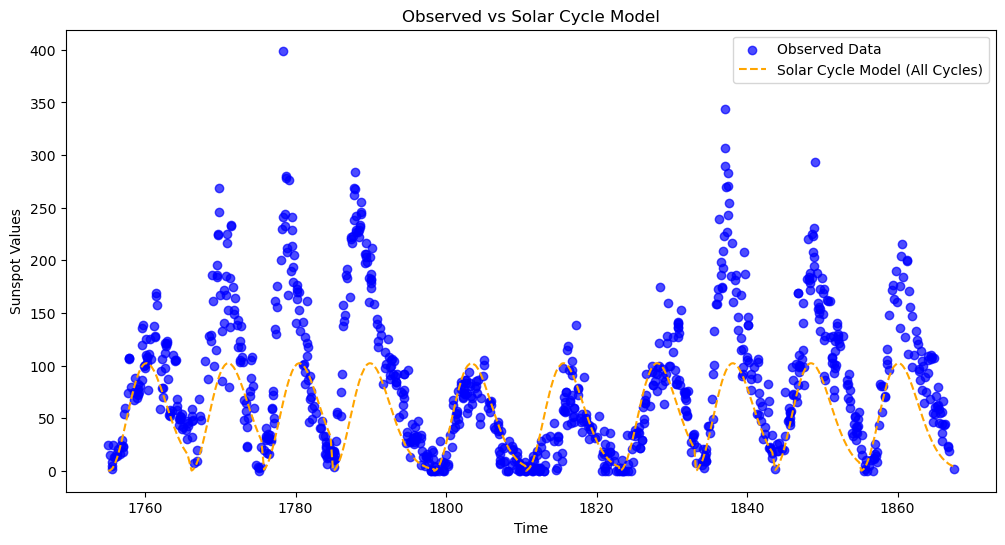

In [7]:
# Compute predictions using the model for all cycles
num_cycles = len(T0_initial)  # Number of cycles based on initial parameters
predicted_values = solar_cycle_model(t, x0, num_cycles=num_cycles)

# Plot observed vs. predicted values (all cycles)
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Solar Cycle Model (All Cycles)", color="orange", linestyle="--")
plt.title("Observed vs Solar Cycle Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()

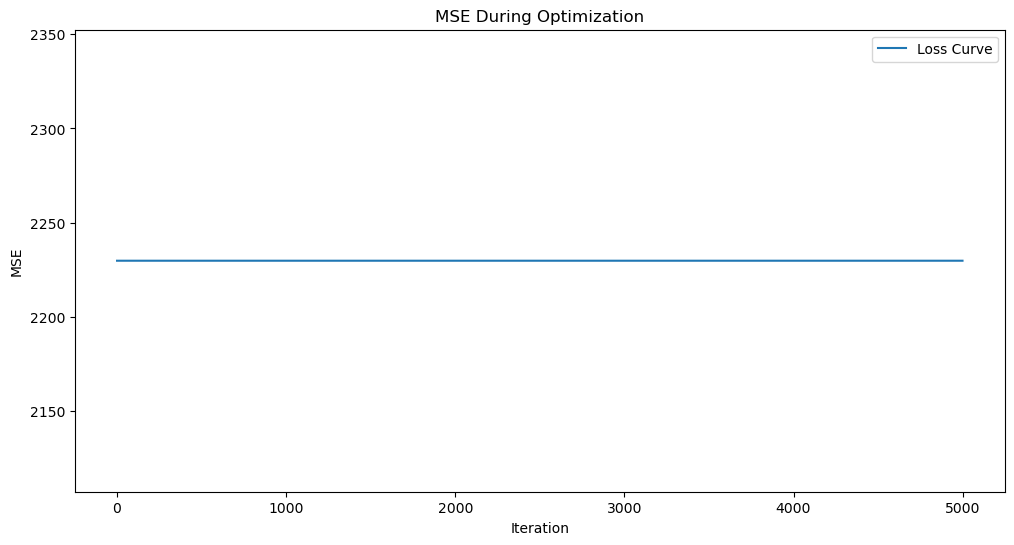

In [11]:
# Define lambda function to wrap mse
loss_function = lambda params: mse(params, t, observed_values)

# Run Simulated Annealing
optimized_params, loss_curve = simulated_annealing(
    x0, T0=10, sigma=0.1, f=loss_function, n_iter=10000, burn_in=5000
)

plt.figure(figsize=(12, 6))
plt.plot(loss_curve, label="Loss Curve")
plt.title("MSE During Optimization")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()



In [16]:
print("Final Parameters:", final_params)
print("Type of Final Parameters:", type(final_params))
final_params = np.array(final_params)
print("Type of Final Parameters:", type(final_params))

optimized_params, _ = simulated_annealing(x0, T0=10, sigma=0.1, f=loss_function, n_iter=10000, burn_in=5000)
final_params = optimized_params  # Ensure this is the full array
optimized_values = solar_cycle_model(t, final_params, num_cycles=len(T0_initial))

print("Optimized Parameters:", optimized_params)
print("Shape of Optimized Parameters:", optimized_params.shape)

Final Parameters: [1.75507476e+03 2.75793299e-01 5.30822364e+00 1.76575920e+03
 1.98431636e-01 4.68829175e+00 1.77532185e+03 2.34452674e-01
 5.17094963e+00 1.78459480e+03 2.08677122e-01 5.24111123e+00
 1.79845441e+03 4.24636101e-01 5.41732860e+00 1.81098809e+03
 8.10415553e-01 4.78282709e+00 1.82281892e+03 2.69043099e-01
 5.07839038e+00 1.83302717e+03 2.16421549e-01 4.86609035e+00
 1.84375030e+03 2.43187620e-01 5.12970979e+00 1.85510478e+03
 2.14554150e-01 5.01327536e+00]
Type of Final Parameters: <class 'numpy.ndarray'>
Type of Final Parameters: <class 'numpy.ndarray'>
Optimized Parameters: [1.75487199e+03 4.64499174e-01 5.37281060e+00 1.76632814e+03
 2.62896056e-01 4.96307376e+00 1.77514455e+03 2.68850220e-01
 5.18580943e+00 1.78438612e+03 1.91795344e-01 4.81310002e+00
 1.79832269e+03 7.43054878e-01 4.74311642e+00 1.81066154e+03
 5.04801954e-01 4.95118992e+00 1.82246209e+03 3.20299125e-01
 5.69634574e+00 1.83270367e+03 1.91043474e-01 4.77594574e+00
 1.84369491e+03 2.28500570e-01 5.07

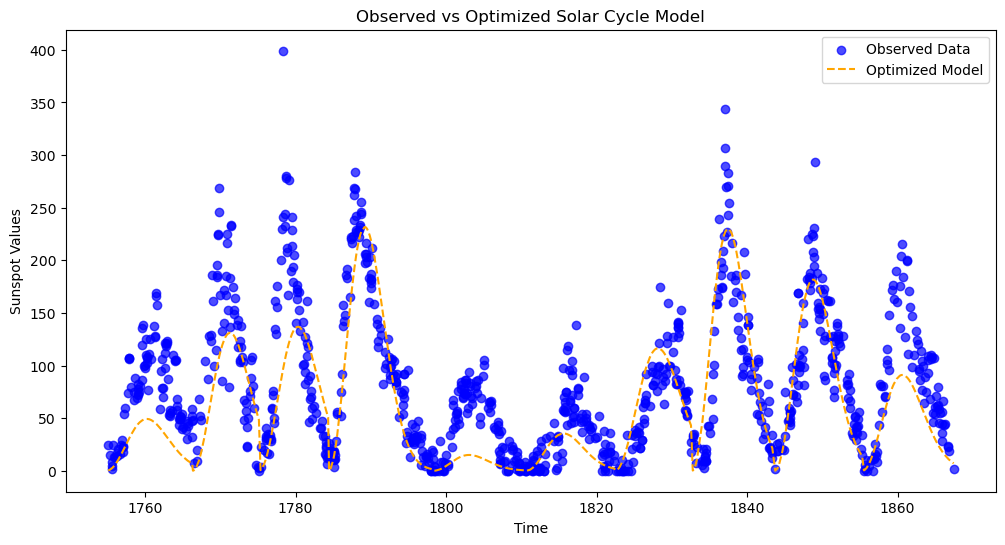

In [17]:
# Ensure params is correct
final_params = optimized_params  # Use the output directly from simulated_annealing

# Validate the length of final_params
assert len(final_params) == 3 * len(T0_initial), "Final parameters length mismatch"

# Compute the optimized model
optimized_values = solar_cycle_model(t, final_params, num_cycles=len(T0_initial))

# Plot the optimized model
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, optimized_values, label="Optimized Model", color="orange", linestyle="--")
plt.title("Observed vs Optimized Solar Cycle Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()


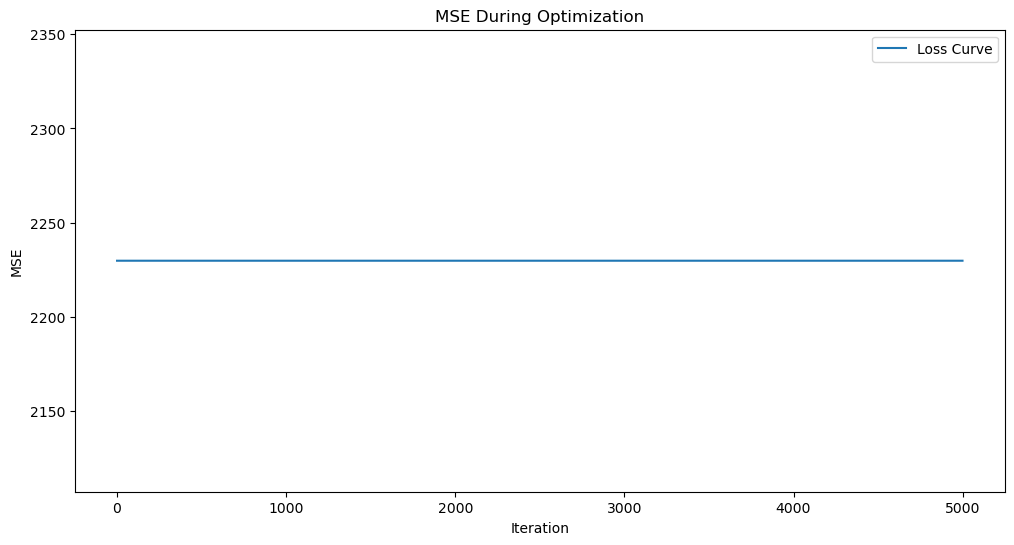

IndexError: invalid index to scalar variable.

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(loss_curve, label="Loss Curve")
plt.title("MSE During Optimization")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

final_params = optimized_params[-1]  # Final optimized parameters
optimized_values = solar_cycle_model(t, final_params, num_cycles=len(T0_initial))

plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, optimized_values, label="Optimized Model", color="orange", linestyle="--")
plt.title("Observed vs Optimized Solar Cycle Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()
